# Project 1b: N-Gram Language Models

Author: Kabir Ahuja

Thanks to Melissa Mitchell and Khushi Khandelwal for feedback and Kavel Rao for designing the autograder.

In this project, you will implement and experiment with N-gram language models. N-gram language models are simplest versions of a language model, which make a simplifying assumption that the probability of predicting a word in a sentence only depends on the past $N$ words in the sentence. In this project you will learn:

- How to train word-level unigram and N-gram LMs on text data
- Evaluating quality of an LM by computing perplexity
- Sampling text from an N-gram LM
- Implement Laplace Smoothing
- Implement Interpolation for N-Gram Language Models

We will be working with Shakespear Plays data from Andrej Karpathy's [blog post on Recurrent neural networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/). We also recommend going through chapter 3 of [Jurafsky and Martin](https://web.stanford.edu/~jurafsky/slp3/3.pdf) on N-Gram models, especially if you are not familiar with them yet.

In [1]:
# Load necessary packages
import os
from typing import List, Dict
import random
import numpy as np
import json
from tqdm import tqdm

# Setup nltk
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

from nltk.tokenize import word_tokenize, sent_tokenize

Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package punkt to C:\Users\Rohan
[nltk_data]     Mukherjee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Rohan
[nltk_data]     Mukherjee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
# !wget https://homes.cs.washington.edu/~kahuja/cse447/project1/data.zip -O data.zip
# !unzip -o data.zip

# Set data directory. Important: DO NOT CHANGE THIS. AUTOGRADER WILL FAIL ON YOUR SUBMISSION OTHERWISE
parent_dir = os.path.dirname(os.path.abspath("__file__"))
data_dir = os.path.join(parent_dir, "data")

In [3]:
# Helper functions for sample test cases

def evaluate_test_case(input, output, expected_output, output_str = "Output", atol=1e-4) -> Dict:
    if input is not None:
        print("Input:\n", input)
    print(f"{output_str}:\n", output)
    print(f"Expected {output_str}:\n", expected_output)

    match = (
        output == expected_output
        if type(output) == str
        else np.allclose(output, expected_output, atol=atol)
    )

    if match:
        print("Test case passed! :)")

    else:
        print("Test case failed! :(")

    print("\n" + "="*50 + "\n")


def evaluate_list_test_case(input: List, output: List, expected_output: List) -> Dict:

    print("Input:\n", input)
    print("Output:\n", output)
    print("Expected output:\n", expected_output)
    if output == expected_output:
        print("Test case passed! :)")

    else:
        print("Test case failed! :(")

    print("\n" + "="*50 + "\n")

## Part 1: Word-level unigram language models (11 points)

We will start by considering word-level language models i.e. language models where the smallest unit (or a unigram) that can be predicted by the model is a word. In part 1, we will implement unigram language models, which constitutes the simplest variant of N-gram models -- simply learn the distribution of each unigram (here a word) in the corpus. Recall from the lectures, that for a text sequence with unigrams $w_1, w_2, \cdots, w_n$, unigram language models, the probability of the sequence is given as:

$$P(w_1, w_2, \cdots, w_n) =P(w_1)P(w_2)\cdots P(w_n)$$

where $P(w_i)$ is simply the frequency of the word $w_i$ in the training corpus.

For this part we will work with the Shakespear dataset. Let's start by loading the datasets

In [4]:
with open(f"{data_dir}/shakespear_train.txt") as f:
    train_data = f.read().split("\n")

with open(f"{data_dir}/shakespear_dev.txt") as f:
    dev_data = f.read().split("\n")

Below we print first 10 sentences from the training data.

In [5]:
print("\n".join(train_data[:10]))

First Citizen : Before we proceed any further , hear me speak .
All : Speak , speak .
First Citizen : You are all resolved rather to die than to famish ?
All : Resolved .
resolved .
First Citizen : First , you know Caius Marcius is chief enemy to the people .
All : We know't , we know't .
First Citizen : Let us kill him , and we 'll have corn at our own price .
Is't a verdict ?
All : No more talking o n't ; let it be done : away , away !


### Exercise 1.0 Text Processing

Before start training our models, let's perform some basic preprocessing. For this exercise, we only want to put an \<eos\> tag at the end of each sentence in the training and dev sets. Implement `add_eos` function below that does that.

In [6]:
def add_eos(data: List[str]) -> List[str]:
    """
    Adds an <eos> token to the end of each line in the data.

    Inputs:
    - data: a list of strings where each string is a line of text

    Returns:
    - a list of strings where each string is a line of text with <eos> token appended
    """
    # YOUR CODE HERE
    return [line + " <eos>" for line in data]

In [7]:
def test_add_eos():
    print("Running Sample Test Case 1")
    data = ["hello!", "world!"]

    evaluate_list_test_case(data, add_eos(data), ["hello! <eos>", "world! <eos>"])

    print("Running Sample Test Case 2")
    data = [
        "Many years later , as he faced the firing squad , Colonel Aureliano Buendía was to remember that distant afternoon when his father took him to discover ice .",
        "At that time Macondo was a village of twenty adobe houses, built on the bank of a river of clear water that ran along a bed of polished stones, which were white and enormous, like prehistoric eggs .",
        "The world was so recent that many things lacked names, and in order to indicate them it was necessary to point ." ]

    expected_output = [
        "Many years later , as he faced the firing squad , Colonel Aureliano Buendía was to remember that distant afternoon when his father took him to discover ice . <eos>",
        "At that time Macondo was a village of twenty adobe houses, built on the bank of a river of clear water that ran along a bed of polished stones, which were white and enormous, like prehistoric eggs . <eos>",
        "The world was so recent that many things lacked names, and in order to indicate them it was necessary to point . <eos>"]
    evaluate_list_test_case(data, add_eos(data), expected_output)

test_add_eos()

Running Sample Test Case 1
Input:
 ['hello!', 'world!']
Output:
 ['hello! <eos>', 'world! <eos>']
Expected output:
 ['hello! <eos>', 'world! <eos>']
Test case passed! :)


Running Sample Test Case 2
Input:
 ['Many years later , as he faced the firing squad , Colonel Aureliano Buendía was to remember that distant afternoon when his father took him to discover ice .', 'At that time Macondo was a village of twenty adobe houses, built on the bank of a river of clear water that ran along a bed of polished stones, which were white and enormous, like prehistoric eggs .', 'The world was so recent that many things lacked names, and in order to indicate them it was necessary to point .']
Output:
 ['Many years later , as he faced the firing squad , Colonel Aureliano Buendía was to remember that distant afternoon when his father took him to discover ice . <eos>', 'At that time Macondo was a village of twenty adobe houses, built on the bank of a river of clear water that ran along a bed of polished

In [8]:
train_data_processed = add_eos(train_data)
dev_data_processed = add_eos(dev_data)

### Exercise 1.1: Training (word-level) Unigram Language Model (2 Points)

Training a unigram model simply corresponds to calculating frequencies of each word in the corpus, i.e.

$$p(w_i) = \frac{C(w_i)}{n}$$

where $C(w_i)$ is the count of word $w_i$ in the training data and $n$ is the total number of words in the training dataset.

Implement the `train_word_unigram` function below

In [9]:
def train_word_unigram(train_data: List[str]) -> Dict[str, float]:

    """
    Trains a word-level unigram language model.

    Inputs:
        - train_data: List[str], list of sentences in training data

    Outputs:
        - Dict[str, float], a dictionary mapping words to their unigram probabilities

    """

    # YOUR CODE HERE
    unigram_probs = nltk.FreqDist([word for line in train_data for word in line.split()])
    total_words = sum(unigram_probs.values())
    for word in unigram_probs:
        unigram_probs[word] /= total_words

    return unigram_probs

In [10]:
unigram_probs = train_word_unigram(train_data_processed)

In [11]:
# Sample test cases
def test_train_word_unigram(unigram_probs):

    print("Running Sample Test Case 1: Check if the number of unique words is correct")
    evaluate_test_case(None, len(unigram_probs), 12610, output_str="Number of unique words")

    print("Running Sample Test Case 2: Check if the probability of word \"thou\" is correct")
    evaluate_test_case("thou", unigram_probs["thou"], 0.004559649641510829)

    print("Running Sample Test Case 3: Check if the probability of word \"love\" is correct")
    evaluate_test_case("love", unigram_probs["love"], 0.0015984182127282134)

    print("Running Sample Test Case 4: Check if the probability of word \"Richard\" is correct")
    evaluate_test_case("Richard", unigram_probs["Richard"], 0.0005035479340675586)

    print("Running Sample Test Case 5: Check if the probability of word \"pytorch\" is correct")
    evaluate_test_case("pytorch", unigram_probs.get("pytorch", 0), 0)

    print("Running Sample Test Case 6: Check if the probability of word \"richard\" is correct")
    evaluate_test_case("richard", unigram_probs.get("richard", 0), 0)


test_train_word_unigram(unigram_probs)

Running Sample Test Case 1: Check if the number of unique words is correct
Number of unique words:
 12610
Expected Number of unique words:
 12610
Test case passed! :)


Running Sample Test Case 2: Check if the probability of word "thou" is correct
Input:
 thou
Output:
 0.004559649641510829
Expected Output:
 0.004559649641510829
Test case passed! :)


Running Sample Test Case 3: Check if the probability of word "love" is correct
Input:
 love
Output:
 0.0015984182127282134
Expected Output:
 0.0015984182127282134
Test case passed! :)


Running Sample Test Case 4: Check if the probability of word "Richard" is correct
Input:
 Richard
Output:
 0.0005035479340675586
Expected Output:
 0.0005035479340675586
Test case passed! :)


Running Sample Test Case 5: Check if the probability of word "pytorch" is correct
Input:
 pytorch
Output:
 0
Expected Output:
 0
Test case passed! :)


Running Sample Test Case 6: Check if the probability of word "richard" is correct
Input:
 richard
Output:
 0
Expected

### Exercise 1.2: Evaluating (word-level) Unigram Language Models using Perplexity (2 Points)

Now that we have trained our first (albeit very basic) language model, our next job is to evaluate how good of a job it does in modeling the training text as well as generalizing on the unseen text. The most commonly used metric for evaluating the quality of a language model is Perplexity. Recall from the lecture, perplexity of a language model on a test dataset measures the (inverse) probability assigned by the language model to the test dataset normalized by the number of words (or tokens). Lower the perplexity the higher probability the model assigns to the text in the test dataset and hence better quality.

$$\text{perplexity}(W) = P(w_1w_2\cdots w_n)^{\frac{-1}{n}} = \sqrt[n]{\frac{1}{P(w_1w_2\cdots w_n)}}$$

where $W$ is a test set with $n$ words $w_1w_2\cdots w_n$

It is useful to do perplexity calculation in log space to avoid numerical issues

$$\text{perplexity}(W) = \exp\bigl(-\frac{\log{P(w_1w_2\cdots w_n)}}{n}\bigr)$$

When we have multiple sentences in the corpus and we assume sentences to be independent, we can write:

$$\text{perplexity}(W) = \exp\bigl(-\frac{ \sum_{S \in W}  \log{P(s_1s_2\cdots s_{n_s})}}{n}\bigr)$$

where $S$ is a sentence in the corpus $W$ with words $s_1 s_2 \cdots s_{n_s}$ and $n_s$ is the number of words in $S$.

Note that assuming sentences to be independent is something that is not actually true in practice. However, since N-gram language models are already limited in their context, it is not the greatest loss to remove dependencies between sentences. In the future homeworks we will be dropping this assumption as we build more powerful models.


In [12]:
def eval_ppl_word_unigram(eval_data: List[str], unigram_probs: Dict[str, float]) -> float:

    """
    Evaluates the perplexity of a word-level unigram language model on the dev set.

    Inputs:
        - dev_data: List[str], list of sentences in the evaluation data
        - unigram_probs: Dict[str, float], a dictionary mapping words to their unigram probabilities

    Outputs:
        - float, the perplexity of the unigram language model on the evaluation set

    Note 1: It is useful to do the calculations in log space and convert the final answer to original space to
    avoid numerical issues .
    Note 2: Assign 0 probability to words that are not in the unigram_probs dictionary, since those words were not seen during training.
    """

    perplexity = 0

    # YOUR CODE HERE
    for line in eval_data:
        for word in line.split():
            perplexity += np.log(unigram_probs.get(word, 0))
    
    return np.exp(-perplexity / sum(len(line.split()) for line in eval_data))

First let's compute the perplexity of training data

In [13]:
train_ppl = eval_ppl_word_unigram(train_data_processed, unigram_probs)
print(train_ppl)

575.1110328373742


You should expect a perplexity around 575 on the training data. Now let's evaluate on dev data.

In [14]:
dev_ppl = eval_ppl_word_unigram(dev_data_processed, unigram_probs)
print(dev_ppl)

inf


C:\Users\Rohan Mukherjee\AppData\Local\Temp\ipykernel_485528\1573223851.py:23: RuntimeWarning: divide by zero encountered in log
  perplexity += np.log(unigram_probs.get(word, 0))


You should see a RuntimeWarning: divide by zero and a perplexity of infinity in this case. Why did this happen? Because we have some words in the dev dataset, which were never seen during training. The unigram model assigns a zero probability to those, which result in an infinite perplexity (inverse probability).

### Exercise 1.3: Handling Unknown Words (2 Points)

How do we deal with such situations? An easy solution is to introduce an unknown word token, e.g. \<unk\>. Before training, we replace the words which occur less than a threshold number of times with an \<unk\> token. E.g., if a word occurs less than 3 times in the dataset, we replace it with the \<unk\> token. At test time, when evaluating the perplexity if we see a word, which was unseen during training i.e. has a unigram frequency of 0, we assign that word the probability of \<unk\> token.

Implement the `replace_rare_words_wth_unks` function below which replaces words which occur less than `unk_thresh` number of times by \<unk\> token. Also reimplement `eval_ppl_word_unigram` to handle unseen words. You might find the [`Counter` class from the `collections` module useful](https://docs.python.org/3/library/collections.html#counter-objects).

In [15]:
def replace_rare_words_wth_unks(train_data: List[str], unk_thresh: int) -> List[str]:
    """
    Replaces words that occur less than unk_thresh times in the training data with "<unk>" token.

    Inputs:
        - train_data: List[str], list of sentences in the training data
        - unk_thresh: int, the threshold on the number of occurrences of a word to be considered known (less than considered <unk>)

    Outputs:
        - List[str], the training text with rare words replaced by "<unk>" token
    """

    word_freq = nltk.FreqDist([word for line in train_data for word in line.split()])
    
    train_data_unked = [" ".join("<unk>" if word_freq[word] < unk_thresh else word for word in line.split()) for line in train_data]

    return train_data_unked

In [16]:
# Sample test cases
def test_train_word_unigram_wth_unks():

    print("# Testing for Threshold 3\n\n")
    train_data_wth_unks = replace_rare_words_wth_unks(train_data_processed, 3)
    unigram_probs_wth_unks = train_word_unigram(train_data_wth_unks)
    print("Sample Test Case 1: Check if the number of unique words is correct")
    evaluate_test_case(None, len(unigram_probs_wth_unks), 4620, output_str="Number of unique words")

    print("Sample Test Case 2: Check if the probability of word \"<unk>\" is correct")
    evaluate_test_case("<unk>", unigram_probs_wth_unks["<unk>"], 0.045185342597383396)

    print("# Testing for threshold 5\n\n")
    train_data_wth_unks = replace_rare_words_wth_unks(train_data_processed, 5)
    unigram_probs_wth_unks = train_word_unigram(train_data_wth_unks)
    print("Sample Test Case 3: Check if the number of unique words is correct")
    evaluate_test_case(None, len(unigram_probs_wth_unks), 3088, output_str="Number of unique words")

    print("Sample Test Case 4: Check if the probability of word \"<unk>\" is correct")
    evaluate_test_case("<unk>", unigram_probs_wth_unks["<unk>"], 0.06910155961268387)

test_train_word_unigram_wth_unks()

# Testing for Threshold 3


Sample Test Case 1: Check if the number of unique words is correct
Number of unique words:
 4620
Expected Number of unique words:
 4620
Test case passed! :)


Sample Test Case 2: Check if the probability of word "<unk>" is correct
Input:
 <unk>
Output:
 0.045185342597383396
Expected Output:
 0.045185342597383396
Test case passed! :)


# Testing for threshold 5


Sample Test Case 3: Check if the number of unique words is correct
Number of unique words:
 3088
Expected Number of unique words:
 3088
Test case passed! :)


Sample Test Case 4: Check if the probability of word "<unk>" is correct
Input:
 <unk>
Output:
 0.06910155961268387
Expected Output:
 0.06910155961268387
Test case passed! :)




In [17]:
# We will remove words that occur less than 3 times
train_data_wth_unks = replace_rare_words_wth_unks(train_data_processed, 10)
unigram_probs_wth_unks = train_word_unigram(train_data_wth_unks)

We recommend you to check the unigram probabilities before and after replacing rare words with \<unk\> token to verify your implementation.

In [18]:
def eval_ppl_word_unigram_wth_unks(eval_data: List[str], unigram_probs_wth_unks: Dict[str, float]) -> float:

    """
    Evaluates the perplexity of a word-level unigram language model on the dev set. For unseen words, uses the <unk> token probability.

    Inputs:
        - eval_data: string, List of sentences in eval data
        - unigram_probs_wth_unks: Dict[str, float], a dictionary mapping words to their unigram probabilities, including <unk> token

    Outputs:
        - float, the perplexity of the unigram language model on the evaluation set

    """

    perplexity = 0

    # YOUR CODE HERE
    for line in eval_data:
        for word in line.split():
            perplexity += np.log(unigram_probs_wth_unks.get(word, unigram_probs_wth_unks["<unk>"]))

    return np.exp(-perplexity / sum(len(line.split()) for line in eval_data))

Let's compute the train and dev perplexity now

In [19]:
train_ppl = eval_ppl_word_unigram_wth_unks(train_data_wth_unks, unigram_probs_wth_unks)
print(f"Train Perplexity: {train_ppl}")
dev_ppl = eval_ppl_word_unigram_wth_unks(dev_data_processed, unigram_probs_wth_unks)
print(f"Dev Perplexity: {dev_ppl}")

Train Perplexity: 216.08200416605456
Dev Perplexity: 167.3194142699338


You should observe a train perplexity around 384 and dev perplexity around 282.

### Exercise 1.4: Sampling from Unigram Language Model (2 Points)

Now that we have trained and evaluated our unigram LM, we are ready to generate some text from it. To sample text from an N-gram language model given prefix words $w_1, w_2, \cdots, w_n$, we sequentially sample next tokens from the N-gram probability distribution given the previous words, i.e.,

$$w_{n+1} \sim P(w_{n+1} | w_{1}, \cdots, w_{n} )$$

For a unigram language model, since $P(w_1, \dots, w_n) = P(w_1)\cdots P(w_n)$ i.e. all words all distributed independently and the next token is sampled independent of previous tokens, the above equation simplifies to:

$$w_{n+1} \sim P(w_{n+1})$$

You will now implement the function `sample_from_word_unigram` below. You might find the [Numpy's random module (np.random)](https://numpy.org/doc/stable/reference/random/index.html) useful.

In [20]:
def sample_from_word_unigram(unigram_probs: Dict[str, float], max_words: int, prefix: str = "") -> str:

    """
    Samples sequence of words from a unigram language model.
    Terminate sampling when either max_words is reached or when <eos> token is sampled.

    Inputs:
        - unigram_probs: Dict[str, float], a dictionary mapping words to their unigram probabilities
        - n_words: int, the number of words to sample
        - prefix: str, a prefix to start the sampling from. Can have multiple words separated by spaces.

    Outputs:
        - str: sampled text i.e. string of sampled words separated by spaces along with the prefix

    # Note: Please use np.random.choice to sample from the unigram_probs dictionary.
    """
    sampled_string = ""
    # YOUR CODE HERE
    for _ in range(max_words):
        sample = np.random.choice(list(unigram_probs.keys()), p=list(unigram_probs.values()), replace=False)
        sampled_string += sample + " "
        if sample == '<eos>':
            break

    return prefix + " " + sampled_string

In [21]:
# Sample test cases
def test_sample_from_word_unigram():

    np.random.seed(0)
    sampled_string = sample_from_word_unigram(unigram_probs_wth_unks, 10, "The king")
    print("Running Test Case 1: Check if the sampled string starts with the prefix")
    evaluate_test_case(None, sampled_string.startswith("The king"), True, output_str="Sampled string starts with the prefix")

    print("Running Test Case 2: Check if the sampled string has either 10 generated words or ends with <eos> token")
    print(f"Generated string: {sampled_string}")
    print(f"Number of generated words: {len(sampled_string.split()) - 2}")
    print(f"Does the generated string end with <eos> token: {'<eos>' in sampled_string}")
    if len(sampled_string.split()) - 2 == 10 or (
        len(sampled_string.split()) - 2 < 10 and "<eos>" in sampled_string
    ):
        print("Test passed! :)")
    else:
        print("Test failed! :(")
    print("\n" + "="*50 + "\n")

    print("Running Test Case 3: Check if the probability of generating <unk> token is correct")

    sampled_strings = [
        sample_from_word_unigram(unigram_probs_wth_unks, 1, "")
        for _ in range(1000)
    ]
    sampled_string = " ".join(sampled_strings)
    num_unks = sampled_string.count("<unk>")
    unk_gen_prob = num_unks / len(sampled_string.split())
    evaluate_test_case(None, unk_gen_prob, unigram_probs_wth_unks["<unk>"], output_str="Probability of generating <unk> token", atol=1e-2)

test_sample_from_word_unigram()

Running Test Case 1: Check if the sampled string starts with the prefix
Sampled string starts with the prefix:
 True
Expected Sampled string starts with the prefix:
 True
Test case passed! :)


Running Test Case 2: Check if the sampled string has either 10 generated words or ends with <eos> token
Generated string: The king I That was I a go ; brother deposed us 
Number of generated words: 10
Does the generated string end with <eos> token: False
Test passed! :)


Running Test Case 3: Check if the probability of generating <unk> token is correct
Probability of generating <unk> token:
 0.121
Expected Probability of generating <unk> token:
 0.10872477640623845
Test case failed! :(




Note that due to the randomness in sampling, it is difficult to automatically test this function. However, you can use the technique we use in sample test case 3 by repeatedly sampling from the unigram model and checking the frequency of different words in the generated text and checking if they are close to the unigram probabilities.

Let's sample some text from the unigram model

In [22]:
for _ in range(5):
    sampled_string = sample_from_word_unigram(unigram_probs_wth_unks, 20)
    print(sampled_string)

 what , <unk> ! : at that <unk> his once <unk> stay my Clarence makes child that <eos> 
 Hermione . on , slain dream see you <unk> <unk> . with . to one answer : ; do part 
 if KING <unk> : might <unk> meet <unk> <unk> greater That in off a : : an , , CATESBY 
 farewell . First queen <unk> <eos> 
 there , <unk> PRINCE my this and thee . KING Within ' , To precious with is me out note 


You should see that the generated that doesn't make a whole lot of sense, which is natural since we are using a unigram model that doesn't account for the context at all, and essentially samples the most common tokens in its generations. We will now move to build language models that do not have this problem, i.e., they take into account the context (albeit to different degrees) for modeling the distribution of words (or tokens) in the text.

## Part 2: N(>1)-Gram Word-Level Language Models (12 Points)

We will now implement much more sophisticated language models, which make use of the surrounding text to model the distribution of text. Recall from the lectures for an $N$-gram language model with $n > 1$, the distribution of a sequence of tokens $w_1, w_2, \cdots, w_n$ is given as:

$$P(w_1, w_2, \cdots, w_n) = \prod_{k=1}^{n}P(w_k \mid w_{k-N-1}, \cdots, w_{k-1})$$

E.g., for a bigram model i.e. $N = 2$, the expression becomes:

$$P(w_1, w_2, \cdots, w_n) = \prod_{k=1}^{n}P(w_k \mid w_{k-1})$$

i.e. the distribution of a token depends solely on the past $N-1$ tokens in the sequence.

In [23]:
# Before we start, lets set training data to be the one with <unk> tokens and dev data to be the one with <eos> tokens in the end

train_data = train_data_wth_unks
dev_data = dev_data_processed

### Exercise 2.1: Text Processing

A careful reader must have noted that the above expression: $P(w_1, w_2, \cdots, w_n) = \prod_{k=1}^{n}P(w_k \mid w_{k-1})$ has a problem. On the right hand side, when $k = 1$, this will result in the term $P(w_1 | w_0)$, but there is no $w_0$ in the sequence. Similarly, for a trigram language model we will have terms, $P(w_1 | w_{-1}, w_{0})$ and $P(w_2 | w_0, w_1)$ with conditionals on words that are not part of the sequence. To handle this issue, we add $N-1$ start of sequence tokens, e.g. \<sos\> to the beginning of the sequence.

Implement `process_text_for_Ngram` function below that adds $N-1$ \<sos\> tokens to beginning of each sentence in the dataset.

In [24]:
def process_text_for_Ngram(sents: List[str], N: int = 2) -> List[str]:

    """
    Adds N-1 <sos> tokens to the start of every sentence in the text.

    Inputs:
        - sents: List[str], List of sentences
        - N: int, the N in N-gram

    Outputs:
        - List[str], the processed text
    """
    processed_sents = ["<sos> " * (N-1) + line for line in sents]

    return processed_sents

In [25]:
# Sample test cases

def test_process_text_for_Ngram():

    sents = ["Many years later , as he faced the firing squad , Colonel Aureliano Buendía was to remember that distant afternoon when his father took him to discover ice .",
    "At that time Macondo was a village of twenty adobe houses, built on the bank of a river of clear water that ran along a bed of polished stones, which were white and enormous, like prehistoric eggs .",
    "The world was so recent that many things lacked names, and in order to indicate them it was necessary to point ." ]

    print("Running Sample Test Case 1 with N=1")
    unigram_processed_text = process_text_for_Ngram(sents, 1)
    excepted_output = [
        "Many years later , as he faced the firing squad , Colonel Aureliano Buendía was to remember that distant afternoon when his father took him to discover ice .",
        "At that time Macondo was a village of twenty adobe houses, built on the bank of a river of clear water that ran along a bed of polished stones, which were white and enormous, like prehistoric eggs .",
        "The world was so recent that many things lacked names, and in order to indicate them it was necessary to point ."
    ]
    evaluate_list_test_case(sents, unigram_processed_text, excepted_output)

    print("Running Sample Test Case 2 with N=2")
    bigram_processed_text = process_text_for_Ngram(sents, 2)
    excepted_output = [
        "<sos> Many years later , as he faced the firing squad , Colonel Aureliano Buendía was to remember that distant afternoon when his father took him to discover ice .",
        "<sos> At that time Macondo was a village of twenty adobe houses, built on the bank of a river of clear water that ran along a bed of polished stones, which were white and enormous, like prehistoric eggs .",
        "<sos> The world was so recent that many things lacked names, and in order to indicate them it was necessary to point ."
    ]
    evaluate_list_test_case(sents, bigram_processed_text, excepted_output)

    print("Running Sample Test Case 3 with N=3")
    trigram_processed_text = process_text_for_Ngram(sents, 3)
    excepted_output = [
        "<sos> <sos> Many years later , as he faced the firing squad , Colonel Aureliano Buendía was to remember that distant afternoon when his father took him to discover ice .",
        "<sos> <sos> At that time Macondo was a village of twenty adobe houses, built on the bank of a river of clear water that ran along a bed of polished stones, which were white and enormous, like prehistoric eggs .",
        "<sos> <sos> The world was so recent that many things lacked names, and in order to indicate them it was necessary to point ."
    ]
    evaluate_list_test_case(sents, trigram_processed_text, excepted_output)

    print("Running Sample Test Case 4 with N=4")
    fourgram_processed_text = process_text_for_Ngram(sents, 4)
    excepted_output = [
        "<sos> <sos> <sos> Many years later , as he faced the firing squad , Colonel Aureliano Buendía was to remember that distant afternoon when his father took him to discover ice .",
        "<sos> <sos> <sos> At that time Macondo was a village of twenty adobe houses, built on the bank of a river of clear water that ran along a bed of polished stones, which were white and enormous, like prehistoric eggs .",
        "<sos> <sos> <sos> The world was so recent that many things lacked names, and in order to indicate them it was necessary to point ."
    ]
    evaluate_list_test_case(sents, fourgram_processed_text, excepted_output)

test_process_text_for_Ngram()

Running Sample Test Case 1 with N=1
Input:
 ['Many years later , as he faced the firing squad , Colonel Aureliano Buendía was to remember that distant afternoon when his father took him to discover ice .', 'At that time Macondo was a village of twenty adobe houses, built on the bank of a river of clear water that ran along a bed of polished stones, which were white and enormous, like prehistoric eggs .', 'The world was so recent that many things lacked names, and in order to indicate them it was necessary to point .']
Output:
 ['Many years later , as he faced the firing squad , Colonel Aureliano Buendía was to remember that distant afternoon when his father took him to discover ice .', 'At that time Macondo was a village of twenty adobe houses, built on the bank of a river of clear water that ran along a bed of polished stones, which were white and enormous, like prehistoric eggs .', 'The world was so recent that many things lacked names, and in order to indicate them it was necessary 

### Exercise 2.2: Implementing N-gram language models (10 Points)

The heart of implementing an N-gram language model is to estimate the conditional distributions $P(w_n \mid w_{n-N-1}, \cdots, w_{n-1})$. Recall from the lectures that the conditional distributions can be estimated as:

$$P(w_n \mid w_{n-N-1}, \cdots, w_{n-1}) = \frac{C(w_{n-N-1} \cdots w_{n-1} w_{n})}{\sum_{w \in W}{C(w_{n-N-1} \cdots w_{n-1} w)}} = \frac{C(w_{n-N-1} \cdots w_{n-1} w_{n})}{{C(w_{n-N-1} \cdots w_{n-1})}}$$

where $C(w_{n-N-1} \cdots w_{n-1} w)$ is the number of times the token sequence $w_{n-N-1} \cdots w_{n-1} w$ appears in the corpus, and $W$ is the vocabulary of the N-gram model.

You will now implement an N-gram language model from scratch. Note that a full implementation involves a `fit` function, which computes the N-gram counts $C(w_{n-N-1} \cdots w_{n-1} w)$ needed to compute the conditional distributions; `eval_perplexity` function, which evaluates the perplexity of the language model on a test set; and a `sample_text` function which generates the text from the LM. Implement the class `WordNGramLM` below with these functions.This time we leave all the implementation details for you to decide. We just provide a boiler plate code, with the expected input output for the three functions in the class. You might need to implement additional functions for your implementation of the three functions.

**Note 1**: If implementing a general NGram Model from scratch seems too daunting, we recommend starting implementing just the Bigram LM and checking if you are able to pass BigramLM Test cases. From there you can work on generalizing your solution.

**Note 2**: Efficiency of your code will be important here, especially for `eval_perplexity` and `sample_text` functions. A naive implementation of these functions will result in a time complexity of $O(nV)$ for `eval_perplexity` and $O(TV)$ for `sample_text`, where $n$ is the number of words in evaluation dataset, T is the length of sampled text, and $V$ is the size of vocabulary. By caching certain quantities during training, you should be able to write implementations with time complexities $O(n + V)$ and $O(T + V)$ for the two functions. We will give only half credit for the naive implementation.

**Note 3**: We will provide sample test cases only to test `eval_perplexity` and `sample_text` functions and not for the `fit` function. Both of the former functions rely on the latter to be implemented correctly, hence use correctness of `eval_perplexity` and `sample_text` to check the correctness of your `fit` function.

In [26]:
class WordNGramLM:

    def __init__(self, N: int):
        self.N = N
        self.ngram_probs = {}
        self.vocabulary = set()
        self.prefix_dict = {}

    def fit(self, train_data: List[str]):

        """
        Trains an N-gram language model.

        Inputs:
            - train_data: str, sentences in the training data

        """

        # YOUR CODE HERE
        train_data = process_text_for_Ngram(train_data, self.N)
        ngrams = self.get_ngrams(train_data)
        
        self.vocabulary = {word for line in train_data for word in line.split()}
        
        ngrams_minus_1 = [" ".join(ngram.split()[:-1]) for ngram in ngrams]
        
        self.prefix_dict = {}
        for ngram in ngrams:
            ngram_minus_1 = " ".join(ngram.split()[:-1])
            if ngram_minus_1 not in self.prefix_dict:
                self.prefix_dict[ngram_minus_1] = [ngram]
            else:
                self.prefix_dict[ngram_minus_1].append(ngram)
        for prefix in self.prefix_dict:
            self.prefix_dict[prefix] = list(set(self.prefix_dict[prefix]))
        
        ngram_probs_minus_1 = nltk.FreqDist(ngrams_minus_1)
        self.ngram_probs = nltk.FreqDist(ngrams)
        
        self.ngram_probs = {
            ngram: self.ngram_probs[ngram] / ngram_probs_minus_1.get(" ".join(ngram.split()[0:self.N-1]))
            for ngram in self.ngram_probs
        }

    def eval_perplexity(self, eval_data: List[str]) -> float:

        """
        Evaluates the perplexity of the N-gram language model on the eval set.

        Input:
            - eval_data: List[str], the evaluation text

        Output:
            - float, the perplexity of the model on the evaluation set

        Note : For words that are not in the vocabulary, replace them with the <unk> token.

        """
        
        # YOUR CODE HERE
        eval_data = process_text_for_Ngram(self.replace_unknown_words_with_unk(eval_data), self.N)
        perplexity = 0
        for line in eval_data:
            words = line.split()
            for i in range(len(words) - self.N + 1):
                ngram = ' '.join(words[i:i+self.N])
                perplexity += np.log(self.ngram_probs.get(ngram, 0))
                
        num_words = sum(len(line.split()) for line in eval_data)
        return np.exp(-perplexity / num_words)

    def sample_text(self, prefix: str = "<sos>", max_words: int = 100) -> str:

        """
        Samples text from the N-gram language model.
        Terminate sampling when either max_words is reached or when <eos> token is sampled.
        Inputs:
            - prefix: str, the prefix to start the sampling from. Can also be multiple words separated by spaces.
            - max_words: int, the maximum number of words to sample

        Outputs:
            - str, the sampled text

        Note: Please use np.random.choice for sampling next words
        """

        # YOUR CODE HERE
        sampled_string = prefix
        for _ in range(max_words):
            prefix = " ".join(sampled_string.split()[-(self.N-1):])
            # ngrams with right prefix
            ngrams = self.prefix_dict.get(prefix, [])
            # if no ngrams with the right prefix, can't generate any more text
            if len(ngrams) == 0:
                break
            p = np.asarray([self.ngram_probs.get(ngram, 0) for ngram in ngrams], dtype=np.float64)
            next_word = np.random.choice([ngram for ngram in ngrams], p=p).split()[-1]
            sampled_string += f" {next_word}"
            if next_word == "<eos>":
                break
            
        return sampled_string

    # Extra utility functions that you think will be useful can go below
    def get_ngrams(self, train_data: List[str]) -> List[str]:
        return [
            ' '.join(line.split()[i:i+self.N]) 
            for line in train_data 
            for i in range(len(line.split()) - self.N + 1)
        ]
    
    def replace_unknown_words_with_unk(self, eval_data: List[str]):
        """
        Replace unknown words in the evaluation data with <unk> token
        """
        return [" ".join([word if word in self.vocabulary else "<unk>" for word in line.split()]) for line in eval_data]

As a sanity check, check if your code returns same perplexities when N=1 as your earlier unigram model perplexities

In [27]:
unigram_lm = WordNGramLM(1)
unigram_lm.fit(train_data)

train_ppl = unigram_lm.eval_perplexity(train_data)
dev_ppl = unigram_lm.eval_perplexity(dev_data)
print(f"Train Perplexity for Unigram model (Class Implementation): {train_ppl}")
print(f"Dev Perplexity for Unigram model (Class Implementation): {dev_ppl}")

train_ppl_old = eval_ppl_word_unigram_wth_unks(train_data_wth_unks, unigram_probs_wth_unks)
dev_ppl_old = eval_ppl_word_unigram_wth_unks(dev_data_processed, unigram_probs_wth_unks)

print(f"Train Perplexity for Unigram model (Original Implementation): {train_ppl_old}")
print(f"Dev Perplexity for Unigram model (Original Implementation): {dev_ppl_old}")

if np.allclose(train_ppl, train_ppl_old, atol = 1e-4) and np.allclose(dev_ppl, dev_ppl_old, atol = 1e-4):
    print("Unigram model perplexities match! :)")

else:
    print("Unigram model perplexities do not match! :(")

Train Perplexity for Unigram model (Class Implementation): 216.08200416605456
Dev Perplexity for Unigram model (Class Implementation): 167.3194142699338
Train Perplexity for Unigram model (Original Implementation): 216.08200416605456
Dev Perplexity for Unigram model (Original Implementation): 167.3194142699338
Unigram model perplexities match! :)


Test implementation of `eval_perplexity` for bigram model

In [28]:
# Test implementation of `eval_perplexity` for bigram model
bigram_lm = WordNGramLM(2)
bigram_lm.fit(train_data)
train_ppl = bigram_lm.eval_perplexity(train_data)
print(f"Train Perplexity: {train_ppl}")
dev_ppl = bigram_lm.eval_perplexity(dev_data)
print(f"Dev Perplexity: {dev_ppl}")

Train Perplexity: 31.947377531986337
Dev Perplexity: inf


C:\Users\Rohan Mukherjee\AppData\Local\Temp\ipykernel_485528\3861553864.py:67: RuntimeWarning: divide by zero encountered in log
  perplexity += np.log(self.ngram_probs.get(ngram, 0))


You should see a train perplexity of roughly 35 and dev perplexity infinite, we will soon see how to deal with that.

Test implementation of `sample_text` for bigram model

In [29]:
def test_sample_text_bigram_model():
    bigram_lm = WordNGramLM(2)
    bigram_lm.fit(train_data)

    random.seed(42)
    np.random.seed(42)
    sampled_text = bigram_lm.sample_text("<sos>", max_words=50)

    print("Test Case 1: Check if the sampled text starts with <sos>")
    evaluate_test_case(None, sampled_text.startswith("<sos>"), True, output_str="Sampled text starts with <sos>")

    print("Test Case 2: Check if the number of generated words is either 50 or less than 50 and ends with <eos>")
    print(f"Generated text: {sampled_text}")
    print(f"Number of generated words: {len(sampled_text.split()) - 1}")
    print(f"Does the generated text end with <eos>: {'<eos>' in sampled_text}")
    if len(sampled_text.split()) - 1 == 50 or (
        len(sampled_text.split()) < 50 and "<eos>" in sampled_text
    ):
        print("Test passed! :)")
    else:
        print("Test failed! :(")

    print("\n" + "="*50 + "\n")

    print("Test Case 3: Check if the probability of generating II is less than III when prefix is RICHARD")
    sampled_texts = [
        bigram_lm.sample_text("RICHARD", max_words=1) for _ in range(10000)
    ]
    sampled_text = " ".join(sampled_texts)
    num_richard_2s = [
        text.split("RICHARD")[1].strip() == "II" for text in sampled_texts
    ].count(True)
    num_richard_3s = [
        text.split("RICHARD")[1].strip() == "III" for text in sampled_texts
    ].count(True)
    gen_prob_richard_2 = num_richard_2s / len(sampled_texts)
    gen_prob_richard_3 = num_richard_3s / len(sampled_texts)

    print(f"Probability of generating Richard II: {gen_prob_richard_2}")
    print(f"Probability of generating Richard III: {gen_prob_richard_3}")
    if gen_prob_richard_2 < gen_prob_richard_3:
        print("Test passed! :)")
    else:
        print("Test failed! :(")

    print("\n" + "="*50 + "\n")

    print(
        "Test Case 4: Check if the probability of generating II given RICHARD  are close to the expected values"
    )
    evaluate_test_case("Richard II", gen_prob_richard_2, 0.35251798561151076, output_str="Probability of generating Richard II", atol=1e-2)

    print(
        "Test Case 5: Check if the probability of generating III given RICHARD are close to the expected values"
    )
    evaluate_test_case("Richard III", gen_prob_richard_3, 0.49640287769784175, output_str="Probability of generating Richard III", atol=1e-2)

test_sample_text_bigram_model()

Test Case 1: Check if the sampled text starts with <sos>
Sampled text starts with <sos>:
 True
Expected Sampled text starts with <sos>:
 True
Test case passed! :)


Test Case 2: Check if the number of generated words is either 50 or less than 50 and ends with <eos>
Generated text: <sos> All seeing thou <unk> , Warwick <unk> their <unk> more , good lord , and teach , Here sits on him , to <unk> of love it seems a hundred , which else <unk> it ! <eos>
Number of generated words: 37
Does the generated text end with <eos>: True
Test passed! :)


Test Case 3: Check if the probability of generating II is less than III when prefix is RICHARD
Probability of generating Richard II: 0.3498
Probability of generating Richard III: 0.504
Test passed! :)


Test Case 4: Check if the probability of generating II given RICHARD  are close to the expected values
Input:
 Richard II
Probability of generating Richard II:
 0.3498
Expected Probability of generating Richard II:
 0.35251798561151076
Test case pass

In [30]:
for _ in range(20):
    sampled_text = bigram_lm.sample_text("<sos> KING", max_words=50)
    print(sampled_text)

<sos> KING RICHARD II : 'T is right : I have <unk> for a match The <unk> this one <unk> and made ; And , if you . <eos>
<sos> KING HENRY VI : I and in one : but is a time of majesty . <eos>
<sos> KING RICHARD II : If you will <unk> show our mercy we <unk> . <eos>
<sos> KING EDWARD IV : How ! <eos>
<sos> KING LEWIS XI : <unk> out The ground Till Bolingbroke : <unk> ; I would all the butcher to wear a dying men 's have him good . <eos>
<sos> KING RICHARD II : Is it By what hour , thou <unk> in this is there 's <unk> life , so <unk> soon out , he let her with all . <eos>
<sos> KING EDWARD IV : My father , Sir Paris ; until it is Hastings , The mighty <unk> that <unk> <unk> with <unk> and marriage . <eos>
<sos> KING RICHARD : O <unk> , sir ; or else I still , <unk> , and you be <unk> to my soul . <eos>
<sos> KING HENRY VI : <unk> , the <unk> them . <eos>
<sos> KING RICHARD III : How long . <eos>
<sos> KING RICHARD II : God ! <eos>
<sos> KING RICHARD : My thoughts , <unk> . <eos>
<sos> KING

The generations should look much better now, way more coherent compared to the unigram model! At least on the surface level it seems to capture the style of Shakespeare's writing.

Test implementation of `eval_perplexity` for trigram, 4-gram, and 5-gram models

In [31]:
trigram_lm = WordNGramLM(3)
trigram_lm.fit(train_data)

train_ppl = trigram_lm.eval_perplexity(train_data)
dev_ppl = trigram_lm.eval_perplexity(dev_data)
print(f"Train Perplexity for Trigram model: {train_ppl}")
print(f"Dev Perplexity for Trigram model: {dev_ppl}")

print("\n\n")

fourgram_lm = WordNGramLM(4)
fourgram_lm.fit(train_data)
train_ppl = fourgram_lm.eval_perplexity(train_data)
dev_ppl = fourgram_lm.eval_perplexity(dev_data)
print(f"Train Perplexity for 4-gram model: {train_ppl}")
print(f"Dev Perplexity for 4-gram model: {dev_ppl}")

print("\n\n")

fivegram_lm = WordNGramLM(5)
fivegram_lm.fit(train_data)
train_ppl = fivegram_lm.eval_perplexity(train_data)
dev_ppl = fivegram_lm.eval_perplexity(dev_data)
print(f"Train Perplexity for 5-gram model: {train_ppl}")
print(f"Dev Perplexity for 5-gram model: {dev_ppl}")

C:\Users\Rohan Mukherjee\AppData\Local\Temp\ipykernel_485528\3861553864.py:67: RuntimeWarning: divide by zero encountered in log
  perplexity += np.log(self.ngram_probs.get(ngram, 0))


Train Perplexity for Trigram model: 6.644587894643117
Dev Perplexity for Trigram model: inf



Train Perplexity for 4-gram model: 2.313972420053016
Dev Perplexity for 4-gram model: inf



Train Perplexity for 5-gram model: 1.5704938250509233
Dev Perplexity for 5-gram model: inf


You should see train perplexities approximately 5.11, 1.89, and 1.48 for trigram, 4-gram, and 5-gram LMs. For dev data the dev perplexity should be infinity for all the three.

Test implementation of `sample_text` for trigram and 4-gram LMs.

In [32]:
def test_sample_text_ngram():

    print("Testing for Trigram model")

    random.seed(42)
    np.random.seed(42)
    trigram_lm = WordNGramLM(3)
    trigram_lm.fit(train_data)
    sampled_text = trigram_lm.sample_text("<sos> <sos>", max_words=50)

    print("Test Case 1: Check if the sampled text starts with <sos> <sos>")
    evaluate_test_case(None, sampled_text.startswith("<sos> <sos>"), True, output_str="Sampled text starts with <sos> <sos>")

    print("Test Case 2: Check if the number of generated words is either 50 or less than 50 and ends with <eos>")
    print(f"Generated text: {sampled_text}")
    print(f"Number of generated words: {len(sampled_text.split()) - 2}")
    print(f"Does the generated text end with <eos>: {'<eos>' in sampled_text}")
    if len(sampled_text.split()) - 2 == 50 or (
        len(sampled_text.split()) - 2 < 50 and "<eos>" in sampled_text
    ):
        print("Test passed! :)")
    else:
        print("Test failed! :(")

    print("\n" + "="*50 + "\n")

    print("Test Case 3: Check if the probability of generating II is greater than III when prefix is KING RICHARD")
    sampled_texts = [
        trigram_lm.sample_text("KING RICHARD", max_words=1) for _ in range(10000)
    ]
    sampled_text = " ".join(sampled_texts)
    num_richard_2s = [
        text.split("KING RICHARD")[1].strip() == "II" for text in sampled_texts
    ].count(True)
    num_richard_3s = [
        text.split("KING RICHARD")[1].strip() == "III" for text in sampled_texts
    ].count(True)

    gen_prob_richard_2 = num_richard_2s / len(sampled_texts)
    gen_prob_richard_3 = num_richard_3s / len(sampled_texts)

    print(f"Probability of generating Richard II: {gen_prob_richard_2}")
    print(f"Probability of generating Richard III: {gen_prob_richard_3}")
    if gen_prob_richard_2 < gen_prob_richard_3:
        print("Test passed! :)")
    else:
        print("Test failed! :(")

    print("\n" + "="*50 + "\n")

    print("Test Case 4: Check if the probability of generating II given KING RICHARD are close to the expected values")
    evaluate_test_case("King Richard II", gen_prob_richard_2, 0.4229, output_str="Probability of generating Richard II", atol=1e-2)

    print("Test Case 5: Check if the probability of generating III given KING RICHARD are close to the expected values")
    evaluate_test_case("King Richard III", gen_prob_richard_3, 0.5771, output_str="Probability of generating Richard III", atol=1e-2)

    print("Testing for 4-gram model")
    random.seed(42)
    np.random.seed(42)
    fourgram_lm = WordNGramLM(4)
    fourgram_lm.fit(train_data)

    sampled_text = fourgram_lm.sample_text("<sos> <sos> <sos>", max_words=50)

    print("Test Case 6: Check if the sampled text starts with <sos> <sos> <sos>")
    evaluate_test_case(None, sampled_text.startswith("<sos> <sos> <sos>"), True, output_str="Sampled text starts with <sos> <sos> <sos>")

    print("Test Case 7: Check if the number of generated words is either 50 or less than 50 and ends with <eos>")
    print(f"Generated text: {sampled_text}")
    print(f"Number of generated words: {len(sampled_text.split()) - 3}")
    print(f"Does the generated text end with <eos>: {'<eos>' in sampled_text}")
    if len(sampled_text.split()) - 3 == 50 or (
        len(sampled_text.split()) - 3 < 50 and "<eos>" in sampled_text
    ):
        print("Test passed! :)")

    else:
        print("Test failed! :(")

    print("\n" + "="*50 + "\n")

    print("Test Case 8: Check if the probability of generating II is greater than III when prefix is <sos> KING RICHARD")
    sampled_texts = [
        fourgram_lm.sample_text("<sos> <sos> KING RICHARD", max_words=1) for _ in range(10000)
    ]
    sampled_text = " ".join(sampled_texts)
    num_richard_2s = [
        text.split("<sos> <sos> KING RICHARD")[1].strip() == "II" for text in sampled_texts
    ].count(True)

    num_richard_3s = [
        text.split("<sos> <sos> KING RICHARD")[1].strip() == "III" for text in sampled_texts
    ].count(True)

    gen_prob_rich2 = num_richard_2s / len(sampled_texts)
    gen_prob_rich3 = num_richard_3s / len(sampled_texts)

    print(f"Probability of generating Richard II: {gen_prob_rich2}")
    print(f"Probability of generating Richard III: {gen_prob_rich3}")
    if gen_prob_rich2 < gen_prob_rich3:
        print("Test passed! :)")
    else:
        print("Test failed! :(")

    print("\n" + "="*50 + "\n")

    print("Test Case 9: Check if the probability of generating II given <sos> KING RICHARD are close to the expected values")
    evaluate_test_case("<sos> King Richard II", gen_prob_rich2, 0.4229, output_str="Probability of generating Richard II", atol=1e-2)

    print("Test Case 10: Check if the probability of generating III given <sos> KING RICHARD are close to the expected values")
    evaluate_test_case("<sos> King Richard III", gen_prob_rich3, 0.5771, output_str="Probability of generating Richard III", atol=1e-2)

test_sample_text_ngram()

Testing for Trigram model
Test Case 1: Check if the sampled text starts with <sos> <sos>
Sampled text starts with <sos> <sos>:
 True
Expected Sampled text starts with <sos> <sos>:
 True
Test case passed! :)


Test Case 2: Check if the number of generated words is either 50 or less than 50 and ends with <eos>
Generated text: <sos> <sos> JULIET : O , she shall not be <unk> , well , she knew well Thy love did read by <unk> on the <unk> of sleep , and see : it is but to my good lord . <eos>
Number of generated words: 39
Does the generated text end with <eos>: True
Test passed! :)


Test Case 3: Check if the probability of generating II is greater than III when prefix is KING RICHARD
Probability of generating Richard II: 0.4227
Probability of generating Richard III: 0.5773
Test passed! :)


Test Case 4: Check if the probability of generating II given KING RICHARD are close to the expected values
Input:
 King Richard II
Probability of generating Richard II:
 0.4227
Expected Probability of ge

In [33]:
np.random.seed(42)
print("Generations from Trigram model")
for _ in range(20):
    sampled_text = trigram_lm.sample_text("<sos> <sos> KING", max_words=50)
    print(sampled_text)

Generations from Trigram model
<sos> <sos> KING EDWARD IV : We must both give and take him down , You can not name the time of day unto your majesty Than all thy happy days on earth to know me : let him not fear . <eos>
<sos> <sos> KING HENRY VI GLOUCESTER : Welcome , my son . <eos>
<sos> <sos> KING RICHARD III : Well , sir ; but grace , despite of all the <unk> of , a friend , I never look 'd on me , But keep our course ; The contrary doth make good against thee , dear God , I pray you , lords , take
<sos> <sos> KING HENRY VI : The gods begin to <unk> ; O , she : Why , brother Gloucester ; For I myself have many <unk> <unk> of our souls And plague <unk> with the eyes Of pity , not <unk> with me . <eos>
<sos> <sos> KING EDWARD IV : See , they are , With all her double <unk> , good fellow . <eos>
<sos> <sos> KING RICHARD III : Tut , I would wish me only he . <eos>
<sos> <sos> KING RICHARD II : Why should she do here <unk> off the rock , the <unk> , The lamb will never more To enter in ,

In [34]:
np.random.seed(42)
random.seed(42)
print("Generations from 4-gram model")
for _ in range(20):
    sampled_text = fourgram_lm.sample_text("<sos> <sos> <sos> KING", max_words=50)
    print(sampled_text)

Generations from 4-gram model
<sos> <sos> <sos> KING HENRY VI : Art thou so <unk> , That horse that I so <unk> have <unk> our <unk> , which she yet <unk> her eyes on me , <unk> . <eos>
<sos> <sos> <sos> KING EDWARD IV : Now , <unk> God , I have here alive , That I might touch that cheek ! <eos>
<sos> <sos> <sos> KING RICHARD III : O Ratcliff , I have lost myself ; I give this heavy <unk> from off my head with my brother 's daughter , And , <unk> <unk> , Then reason <unk> with you . <eos>
<sos> <sos> <sos> KING EDWARD IV : But , more of thy news ? <eos>
<sos> <sos> <sos> KING RICHARD II : How high a <unk> , Or I with grief and sorrow , to the king my brother ; there my father 's grave Did <unk> forth a voice . <eos>
<sos> <sos> <sos> KING RICHARD II : The devil take Henry of Lancaster , resign thy crown . <eos>
<sos> <sos> <sos> KING HENRY VI EDWARD : I thank your good worship . <eos>
<sos> <sos> <sos> KING HENRY VI : O Clifford , but <unk> <unk> and <unk> sins , The <unk> he that <unk>

In [35]:
np.random.seed(42)
random.seed(42)
print("Generations from 5-gram model")
for _ in range(20):
    sampled_text = fivegram_lm.sample_text("<sos> <sos> <sos> <sos> KING", max_words=50)
    print(sampled_text)

Generations from 5-gram model
<sos> <sos> <sos> <sos> KING RICHARD III : <unk> thou not , <unk> ? ' <eos>
<sos> <sos> <sos> <sos> KING EDWARD IV : Take that , and that : if all this will not do , I 'll drown you in the <unk> within . <eos>
<sos> <sos> <sos> <sos> KING RICHARD III : Give me another horse : <unk> up my wounds . <eos>
<sos> <sos> <sos> <sos> KING EDWARD IV : An easy <unk> ; 't is but to love a king . <eos>
<sos> <sos> <sos> <sos> KING EDWARD IV : Clarence and Gloucester , love my <unk> queen ; And kiss your princely <unk> , brothers both . <eos>
<sos> <sos> <sos> <sos> KING RICHARD II : <unk> cousin ! <eos>
<sos> <sos> <sos> <sos> KING RICHARD III : There let him <unk> , and be <unk> : and farewell , good fellow . <eos>
<sos> <sos> <sos> <sos> KING EDWARD IV : Now , <unk> God , I am so <unk> , that <unk> with thine eyes at once see good and evil , <unk> to them both : were my wife 's <unk> , her womb 's <unk> , And make <unk> a bark of <unk> kind By
<sos> <sos> <sos> <sos

You should see that the generation quality is now so much better. However, if you look closely (this is specially true for 4-gram and 5-gram models) that some of the sentences are directly lifted from the training data. Which makes sense, as we will increase the order of the N-gram LM, so does we increase its capacity and hence more the ability to memorize its training data.

## Part 3: Smoothing and Interpolation (27 Points)

The issue with using N-gram language models is that any finite training corpus is bound to miss some N-grams that appear in the test set. The models hence assign zero probability to such N-grams, leading to probability of the entire test set to be zero and hence infinite perplexity values that we observed in the previous exercise.

The standard way to deal with zero-probability N-gram tokens is to use smoothing algorithms. Smoothing algorithms shave off a bit of probability mass from some more frequent events and give it to unseen events. Smoothing algorithms for N-gram language models is a well studied area of research with numerous algorithms. For this project we will focus on Laplace Smoothing and Interpolation.

### Exercise 3.1 Laplace and Add-k Smoothing (10 Points)

Perhaps the simplest smoothing algorithm that exists is Laplace smoothing. It merely adds one to count of each N-gram, so that there is no zero-probability N-gram in the test data. For a bigram model, the expression for Laplace-smoothened distribution is given by:

$$P_{\text{Laplace}}(w_n \mid w_{n-1}) = \frac{C(w_{n-1}w_{n}) + 1}{\sum_{w \in W} (C(w_n w) + 1) } = \frac{C(w_{n-1}w_{n}) + 1}{ C(w_{n-1}) + V }$$

We can similarly write expressions for other N-gram models.

Laplace smoothing is also called "Add-one" smoothing. A generalization of Laplace Smoothing is "Add-k" smoothing with  with $k < 1$, where we move a bit less of the probability mass from seen to unseen N-grams. The expression for Add-k smoothened distribution for bigram LM is given by:

$$P_{\text{Add-k}}(w_n \mid w_{n -1}) = \frac{C(w_{n-1}w_{n}) + k}{\sum_{w \in W} (C(w_n w) + k) } = \frac{C(w_{n-1}w_{n}) + 1}{ C(w_{n-1}) + kV }$$

For this exercise, we ask you to implement `WordNGramLMWithAddKSmoothing` class. You need to follow the same code structure as `WordNGramLM` class, with only difference being in calculation of the conditional distributions.

Note: It is no longer possible to implement an $O(T + V)$ time complexity solution for `sample_text` function, hence we will accept $O(TV)$ implementations here. Your `eval_perplexity` should still be as efficient as in the `WordNGramLM`


In [36]:
class WordNGramLMWithAddKSmoothing(WordNGramLM):

    def __init__(self, N: int, k: float = 1):
        super().__init__(N)
        self.k = k
        self.prefix_counts = {}

    def fit(self, train_data: List[str]):
        """
        Trains an N-gram language model with Add-k smoothing.

        Inputs:
            - train_data: str, sentences in the training data

        """

        # YOUR CODE HERE
        train_data = process_text_for_Ngram(train_data, self.N)
        
        ngrams = self.get_ngrams(train_data)
        self.vocabulary = {word for line in train_data for word in line.split()}
        self.ngram_probs = nltk.FreqDist(ngrams)
        self.prefix_counts = nltk.FreqDist([" ".join(ngram.split()[:-1]) for ngram in ngrams])
            
        for ngram in self.ngram_probs:
            prefix = ' '.join(ngram.split()[:-1])
            self.ngram_probs[ngram] = (
                    (self.ngram_probs[ngram] + self.k) 
                                        / 
                    (self.prefix_counts[prefix] + self.k * len(self.vocabulary))
            )

    def eval_perplexity(self, eval_data: List[str]) -> float:
        """
        Evaluates the perplexity of the N-gram language model with Add-k smoothing on the eval set.

        Input:
            - eval_data: List[str], the evaluation text

        Output:
            - float, the perplexity of the model on the evaluation set

        Note : For tokens that are not in the vocabulary, replace them with the <unk> token.

        """
        
        # YOUR CODE HERE
        eval_data = process_text_for_Ngram(self.replace_unknown_words_with_unk(eval_data), self.N)
        perplexity = 0
        for line in eval_data:
            words = line.split()
            for i in range(len(words) - self.N + 1):
                ngram = ' '.join(words[i:i+self.N])
                prefix = ' '.join(words[i:i+self.N-1])
                default = self.k / (self.prefix_counts.get(prefix, 0) + self.k * len(self.vocabulary))
                perplexity += np.log(self.ngram_probs.get(ngram, default))
        num_words = sum(len(line.split()) for line in eval_data)
        perplexity = np.exp(-perplexity/num_words)
        return perplexity

    def sample_text(
        self, prefix: str = "<sos>", max_words: int = 100,
    ) -> str:
        """
        Samples text from the N-gram language model.

        Inputs:
            - prefix: str, the prefix to start the sampling from. Can also be multiple words separated by spaces.
            - max_words: int, the maximum number of words to sample

        Outputs:
            - str, the sampled text

        Note: Please use np.random.choice for sampling next words
        """

        # YOUR CODE HERE
        sample = prefix
        for _ in range(max_words):
            prefix_words = sample.split()[-self.N+1:]
            prefix = ' '.join(prefix_words)
            # ngrams with right prefix
            ngrams = [prefix + f' {word}' for word in self.vocabulary]
            default = self.k / (self.prefix_counts.get(prefix, 0) + self.k * len(self.vocabulary))
            p = np.asarray([self.ngram_probs.get(ngram, default) for ngram in ngrams], dtype=np.float64)
            # numerical instability--0.9999999992 doesn't count as 1
            p /= np.sum(p)
            next_word = np.random.choice(ngrams, p=p).split()[-1]
            sample += f' {next_word}'
            if next_word == "<eos>":
                break
        return sample

    # Extra utility functions that you think will be useful can go below
    # YOUR CODE HERE
    def get_ngrams_with_n(self, train_data: List[str], n: int):
        return [
            ' '.join(line.split()[i:i+n]) 
            for line in train_data 
            for i in range(len(line.split()) -  n + 1)
        ]

Test implementation of `eval_perplexity` for bigram model with Laplace smoothing

In [37]:
# Test implementation of `eval_perplexity` for bigram model with Laplace smoothing
bigram_lm = WordNGramLMWithAddKSmoothing(2, k = 1)
bigram_lm.fit(train_data)
train_ppl = bigram_lm.eval_perplexity(train_data)
print(f"Train Perplexity: {train_ppl}")
dev_ppl = bigram_lm.eval_perplexity(dev_data)
print(f"Dev Perplexity: {dev_ppl}")

Train Perplexity: 110.82226577600021
Dev Perplexity: 103.6725038252657


You should get a train perplexity around 310 and dev perplexity around 294. Notice how the dev perplexity is not $\infty$ anymore! Though it comes at the cost of an increase in perplexity on training data, which is natural since the model now cut offs some probability mass from training N-grams and distribute it to the unseen ones.

Test implementation of `eval_perplexity` for bigram model with Add-k smoothing (k = 0.01)

In [38]:
# Test implementation of `eval_perplexity` for bigram model with Add-k smoothing
bigram_lm = WordNGramLMWithAddKSmoothing(2, k=0.01)
bigram_lm.fit(train_data)
train_ppl = bigram_lm.eval_perplexity(train_data)
print(f"Train Perplexity: {train_ppl}")
dev_ppl = bigram_lm.eval_perplexity(dev_data)
print(f"Dev Perplexity: {dev_ppl}")

Train Perplexity: 35.36882821633253
Dev Perplexity: 58.42884264436245


You should get a train perplexity around 50 and a dev perplexity of roughly 116. Notice how we do much better on train perplexity when k is smaller, since now we re-distribute much less of the mass from the training N-grams. Luckily, in this case it turns out it improves the dev perplexity too.

Dev Perplexity for 2-gram model, k = 1e-08: 240.35384723333948
Dev Perplexity for 2-gram model, k = 1e-07: 187.14889255595693
Dev Perplexity for 2-gram model, k = 1e-06: 145.72277584120175
Dev Perplexity for 2-gram model, k = 1e-05: 113.47690880288064
Dev Perplexity for 2-gram model, k = 0.0001: 88.44733973090366
Dev Perplexity for 2-gram model, k = 0.001: 69.54721649156888
Dev Perplexity for 2-gram model, k = 0.01: 58.42884264436245
Dev Perplexity for 2-gram model, k = 0.1: 62.92589464237486
Dev Perplexity for 2-gram model, k = 1.0: 103.6725038252657
Dev Perplexity for 3-gram model, k = 1e-08: 3848.6407558293004
Dev Perplexity for 3-gram model, k = 1e-07: 1941.397959401587
Dev Perplexity for 3-gram model, k = 1e-06: 979.4673080773732
Dev Perplexity for 3-gram model, k = 1e-05: 494.92920864778705
Dev Perplexity for 3-gram model, k = 0.0001: 253.80766680998696
Dev Perplexity for 3-gram model, k = 0.001: 144.11883456396177
Dev Perplexity for 3-gram model, k = 0.01: 113.74890370049853
Dev

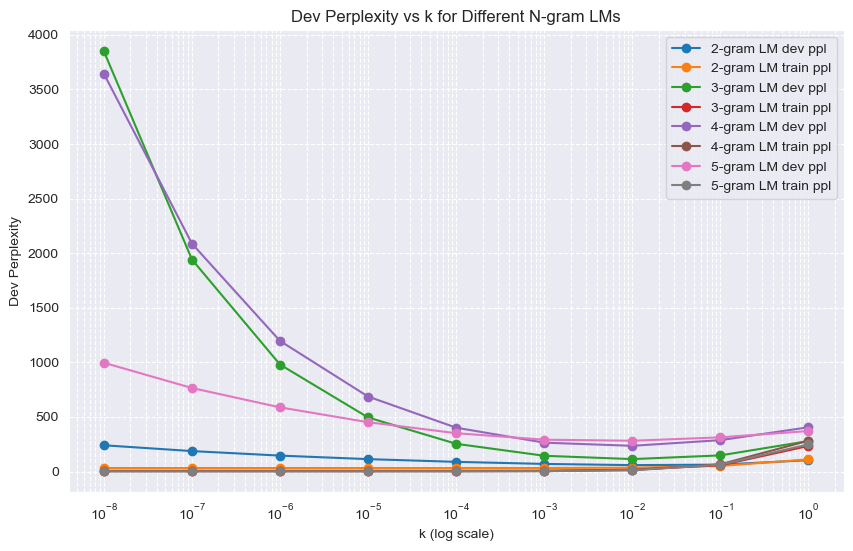

In [39]:
import matplotlib.pyplot as plt

ks = np.logspace(-8, 0, 9)
dev_ppl_dict = {N: [] for N in range(2,6)}
train_ppl_dict = {N: [] for N in range(2,6)}
for N in range(2, 6):
    for k in ks:
        lm = WordNGramLMWithAddKSmoothing(N, k=k)
        lm.fit(train_data)
        dev_ppl = lm.eval_perplexity(dev_data)
        train_ppl = lm.eval_perplexity(train_data)
        train_ppl_dict[N].append(train_ppl)
        dev_ppl_dict[N].append(dev_ppl)
        print(f"Dev Perplexity for {N}-gram model, k = {k}: {dev_ppl}")

# Plotting
plt.figure(figsize=(10, 6))
for N in range(2, 6):
    plt.plot(ks, dev_ppl_dict[N], marker='o', linestyle='-', label=f'{N}-gram LM dev ppl')
    plt.plot(ks, train_ppl_dict[N], marker='o', linestyle='-', label=f'{N}-gram LM train ppl')


plt.xscale('log')
plt.xlabel('k (log scale)')
plt.ylabel('Dev Perplexity')
plt.title('Dev Perplexity vs k for Different N-gram LMs')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

Test implementation of `sample_text` for bigram model with Laplace Smoothing

In [53]:
def test_sample_text_bigram_laplace_model():
    bigram_lm = WordNGramLMWithAddKSmoothing(2, k = 1)
    bigram_lm.fit(train_data_wth_unks)

    # random.seed(42)
    np.random.seed(42)
    sampled_text = bigram_lm.sample_text("<sos>", max_words=50)

    print("Test Case 1: Check if the sampled text starts with <sos>")
    evaluate_test_case(
        None,
        sampled_text.startswith("<sos>"),
        True,
        output_str="Sampled text starts with <sos>",
    )

    print(
        "Test Case 2: Check if the number of generated words is either 50 or less than 50 and ends with <eos>"
    )
    print(f"Generated text: {sampled_text}")
    print(f"Number of generated words: {len(sampled_text.split()) - 1}")
    print(f"Does the generated text end with <eos>: {'<eos>' in sampled_text}")
    if len(sampled_text.split()) - 1 == 50 or (
        len(sampled_text.split()) < 50 and "<eos>" in sampled_text
    ):
        print("Test passed! :)")
    else:
        print("Test failed! :(")

    print("\n" + "=" * 50 + "\n")

    print(
        "Test Case 3: Check if the probability of generating II is greater than III when prefix is RICHARD"
    )
    sampled_texts = [
        bigram_lm.sample_text("RICHARD", max_words=1) for _ in range(1000)
    ]
    sampled_text = " ".join(sampled_texts)
    num_richard_2s = [
        text.split("RICHARD")[1].strip() == "II" for text in sampled_texts
    ].count(True)
    num_richard_3s = [
        text.split("RICHARD")[1].strip() == "III" for text in sampled_texts
    ].count(True)
    gen_prob_richard_2 = num_richard_2s / len(sampled_texts)
    gen_prob_richard_3 = num_richard_3s / len(sampled_texts)

    print(f"Probability of generating Richard II: {gen_prob_richard_2}")
    print(f"Probability of generating Richard III: {gen_prob_richard_3}")
    if gen_prob_richard_2 < gen_prob_richard_3:
        print("Test passed! :)")
    else:
        print("Test failed! :(")

    print("\n" + "=" * 50 + "\n")

    print(
        "Test Case 4: Check if the probability of generating II given RICHARD  are close to the expected values"
    )
    evaluate_test_case(
        "Richard II",
        gen_prob_richard_2,
        0.023,
        output_str="Probability of generating Richard II",
        atol=1e-3,
    )

    print(
        "Test Case 5: Check if the probability of generating III given RICHARD are close to the expected values"
    )
    evaluate_test_case(
        "Richard III",
        gen_prob_richard_3,
        0.034,
        output_str="Probability of generating Richard III",
        atol=1e-3,
    )

test_sample_text_bigram_laplace_model()

Test Case 1: Check if the sampled text starts with <sos>
Sampled text starts with <sos>:
 True
Expected Sampled text starts with <sos>:
 True
Test case passed! :)


Test Case 2: Check if the number of generated words is either 50 or less than 50 and ends with <eos>
Generated text: <sos> record punishment ah according an MARGARET apothecary PRINCE refuse moveables visage hardy speech drew whispering Draw scatter rests crutch after requires that sings gates disease voice besides lent rising prettiest hide teeming winged Catesby nightingale evil flow God above world until thousand where walls green And red Montagues places struck
Number of generated words: 50
Does the generated text end with <eos>: False
Test passed! :)


Test Case 3: Check if the probability of generating II is greater than III when prefix is RICHARD
Probability of generating Richard II: 0.029
Probability of generating Richard III: 0.021
Test failed! :(


Test Case 4: Check if the probability of generating II given RICHA

In [54]:
random.seed(42)
np.random.seed(42)
bigram_lm = WordNGramLMWithAddKSmoothing(2, k = 1)
bigram_lm.fit(train_data)
for _ in range(20):
    sampled_text = bigram_lm.sample_text("<sos> KING", max_words=50)
    print(sampled_text)

<sos> KING humour set'st Of tomorrow sickly an holp lusty follow Hallowmas visage hardy speech drew whispering Draw scatter rests crutch after requires that sings gates disease voice besides lent rising prettiest hide teeming winged Catesby nightingale evil flow God above world until thousand where walls green And red Montagues places struck
<sos> KING temper Soft Kind scars parlous foolish forget caparison violence heavily sire hearts sap therefore mother know that exile appetite well lies overthrow public speaks 'longs Be fancy PERDITA crept Six be't innocents herbs correction Beseech Nature pierce jealous simple leader divines confirm even discourse To-morrow Into words read aught understanding
<sos> KING ceremonious plants windows faction chaste physician seven flatter Isabella prison naught cousins belike marvel Saw jealousies His save mine flesh marvel food crows do boar Hast farewell PRINCE injury bosoms Tush long Has flower CLIFFORD heavily names vessel villain pines pieces cho

You should see generations which are much less like training data! <sos> KING is now followed by words other than name of king names like before. Though the generations are much less clean now.

In [55]:
random.seed(42)
np.random.seed(42)
bigram_lm = WordNGramLMWithAddKSmoothing(2, k=0.01)
bigram_lm.fit(train_data)
for _ in range(20):
    sampled_text = bigram_lm.sample_text("<sos> KING", max_words=50)
    print(sampled_text)

<sos> KING HENRY Anon Greece brought you must PAGE : Poor queen hath made between a new struck Old springs bitterly Bushy shelter wounds ? <eos>
<sos> KING LEWIS ship to wash lineaments solace mildly was't QUEEN : 'Twere deserve nose pronounced pays himself nights musty willingly meat drum battles hereafter stronger slaves to lose , which side CAPULET : If you deny become charge thy soul nobleness impose fall wholesome 'fore triumphant Worthy Him needy gage ,
<sos> KING RICHARD II : Sir <unk> is heirs ' minds ashes bishop 's sake speaks , <unk> bear state , and mind Still <unk> <unk> such removed pay servants Pembroke cherish Westminster Lay hands , cheer boots swifter Weep weeps affect With wisdom ghostly gilt , and welcome 'The needs odd
<sos> KING EDWARD IV : His banish 'd ; But that name thee too <unk> of no further . <eos>
<sos> KING know underneath her at liberty follow profits relish William obey you know his country woful Peter daughters physic native AUFIDIUS : A man , That go

Notice how with a smaller value of $k$, the generated sentences now start to resemble more with the training data

Test implementation of `eval_perplexity` for trigram, 4-gram, and 5-gram LMs with Laplace smoothing

In [56]:
trigram_lm = WordNGramLMWithAddKSmoothing(3, k =1)
trigram_lm.fit(train_data_wth_unks)

train_ppl = trigram_lm.eval_perplexity(train_data_wth_unks)
dev_ppl = trigram_lm.eval_perplexity(dev_data)
print(f"Train Perplexity for Trigram model: {train_ppl}")
print(f"Dev Perplexity for Trigram model: {dev_ppl}")

print("\n\n")

fourgram_lm = WordNGramLMWithAddKSmoothing(4, k =1)
fourgram_lm.fit(train_data_wth_unks)
train_ppl = fourgram_lm.eval_perplexity(train_data_wth_unks)
dev_ppl = fourgram_lm.eval_perplexity(dev_data)
print(f"Train Perplexity for 4-gram model: {train_ppl}")
print(f"Dev Perplexity for 4-gram model: {dev_ppl}")

print("\n\n")

fivegram_lm = WordNGramLMWithAddKSmoothing(5, k =1)
fivegram_lm.fit(train_data_wth_unks)
train_ppl = fivegram_lm.eval_perplexity(train_data_wth_unks)
dev_ppl = fivegram_lm.eval_perplexity(dev_data)
print(f"Train Perplexity for 5-gram model: {train_ppl}")
print(f"Dev Perplexity for 5-gram model: {dev_ppl}")

Train Perplexity for Trigram model: 701.9762158904289
Dev Perplexity for Trigram model: 931.0303442648889



Train Perplexity for 4-gram model: 697.7793845964452
Dev Perplexity for 4-gram model: 1080.1678891720715



Train Perplexity for 5-gram model: 564.4994161169815
Dev Perplexity for 5-gram model: 875.319250249223


You should roughly observe the following perplexities:

|N-gram LM | Train Perplexity | Dev Perplexity|
|----------|------------------|---------------|
| Trigram   | 701              | 931           |
| 4-gram  | 685              | 1080         |
| 5-gram | 586 | 875 |


Test implementation of `sample_text` for trigram and 4-gram LMs with Laplace Smoothing

In [57]:
def test_sample_text_ngram_laplace():
    print("Testing for Trigram model")

    random.seed(42)
    np.random.seed(42)
    trigram_lm = WordNGramLMWithAddKSmoothing(3)
    trigram_lm.fit(train_data)
    sampled_text = trigram_lm.sample_text("<sos> <sos>", max_words=50)

    print("Test Case 1: Check if the sampled text starts with <sos> <sos>")
    evaluate_test_case(
        None,
        sampled_text.startswith("<sos> <sos>"),
        True,
        output_str="Sampled text starts with <sos> <sos>",
    )

    print(
        "Test Case 2: Check if the number of generated words is either 50 or less than 50 and ends with <eos>"
    )
    print(f"Generated text: {sampled_text}")
    print(f"Number of generated words: {len(sampled_text.split()) - 2}")
    print(f"Does the generated text end with <eos>: {'<eos>' in sampled_text}")
    if len(sampled_text.split()) - 2 == 50 or (
        len(sampled_text.split()) - 2 < 50 and "<eos>" in sampled_text
    ):
        print("Test passed! :)")
    else:
        print("Test failed! :(")

    print("\n" + "=" * 50 + "\n")

    print(
        "Test Case 3: Check if the probability of generating II is less than III when prefix is KING RICHARD"
    )
    sampled_texts = [
        trigram_lm.sample_text("KING RICHARD", max_words=1) for _ in range(10000)
    ]
    sampled_text = " ".join(sampled_texts)
    num_richard_2s = [
        text.split("KING RICHARD")[1].strip() == "II" for text in sampled_texts
    ].count(True)
    num_richard_3s = [
        text.split("KING RICHARD")[1].strip() == "III" for text in sampled_texts
    ].count(True)

    gen_prob_richard_2 = num_richard_2s / len(sampled_texts)
    gen_prob_richard_3 = num_richard_3s / len(sampled_texts)

    print(f"Probability of generating Richard II: {gen_prob_richard_2}")
    print(f"Probability of generating Richard III: {gen_prob_richard_3}")
    if gen_prob_richard_2 < gen_prob_richard_3:
        print("Test passed! :)")
    else:
        print("Test failed! :(")

    print("\n" + "=" * 50 + "\n")

    print(
        "Test Case 4: Check if the probability of generating II given KING RICHARD are close to the expected values"
    )
    evaluate_test_case(
        "King Richard II",
        gen_prob_richard_2,
        0.0201,
        output_str="Probability of generating Richard II",
        atol=1e-2,
    )

    print(
        "Test Case 5: Check if the probability of generating III given KING RICHARD are close to the expected values"
    )
    evaluate_test_case(
        "King Richard III",
        gen_prob_richard_3,
        0.0306,
        output_str="Probability of generating Richard III",
        atol=1e-2,
    )

    print("Testing for 4-gram model")
    fourgram_lm = WordNGramLMWithAddKSmoothing(4)
    fourgram_lm.fit(train_data)
    sampled_text = fourgram_lm.sample_text("<sos> <sos> <sos>", max_words=50)

    print("Test Case 6: Check if the sampled text starts with <sos> <sos> <sos>")
    evaluate_test_case(
        None,
        sampled_text.startswith("<sos> <sos> <sos>"),
        True,
        output_str="Sampled text starts with <sos> <sos> <sos>",
    )

    print(
        "Test Case 7: Check if the number of generated words is either 50 or less than 50 and ends with <eos>"
    )
    print(f"Generated text: {sampled_text}")
    print(f"Number of generated words: {len(sampled_text.split()) - 3}")
    print(f"Does the generated text end with <eos>: {'<eos>' in sampled_text}")
    if len(sampled_text.split()) - 3 == 50 or (
        len(sampled_text.split()) - 3 < 50 and "<eos>" in sampled_text
    ):
        print("Test passed! :)")

    else:
        print("Test failed! :(")

    print("\n" + "=" * 50 + "\n")

    print(
        "Test Case 8: Check if the probability of generating II is less than III when prefix is <sos> KING RICHARD"
    )
    sampled_texts = [
        fourgram_lm.sample_text("<sos> <sos> KING RICHARD", max_words=1)
        for _ in range(1000)
    ]
    sampled_text = " ".join(sampled_texts)
    num_richard_2s = [
        text.split("<sos> <sos> KING RICHARD")[1].strip() == "II"
        for text in sampled_texts
    ].count(True)

    num_richard_3s = [
        text.split("<sos> <sos> KING RICHARD")[1].strip() == "III"
        for text in sampled_texts
    ].count(True)

    gen_prob_rich2 = num_richard_2s / len(sampled_texts)
    gen_prob_rich3 = num_richard_3s / len(sampled_texts)

    print(f"Probability of generating Richard II: {gen_prob_rich2}")
    print(f"Probability of generating Richard III: {gen_prob_rich3}")
    if gen_prob_rich2 < gen_prob_rich3:
        print("Test passed! :)")
    else:
        print("Test failed! :(")

    print("\n" + "=" * 50 + "\n")

    print(
        "Test Case 9: Check if the probability of generating II given <sos> KING RICHARD are close to the expected values"
    )
    evaluate_test_case(
        "<sos> King Richard II",
        gen_prob_rich2,
        0.0174,
        output_str="Probability of generating Richard II",
        atol=1e-2,
    )

    print(
        "Test Case 10: Check if the probability of generating III given <sos> KING RICHARD are close to the expected values"
    )
    evaluate_test_case(
        "<sos> King Richard III",
        gen_prob_rich3,
        0.0295,
        output_str="Probability of generating Richard III",
        atol=1e-2,
    )
test_sample_text_ngram_laplace()

Testing for Trigram model
Test Case 1: Check if the sampled text starts with <sos> <sos>
Sampled text starts with <sos> <sos>:
 True
Expected Sampled text starts with <sos> <sos>:
 True
Test case passed! :)


Test Case 2: Check if the number of generated words is either 50 or less than 50 and ends with <eos>
Generated text: <sos> <sos> record set'st No For sickly sickly commends pursue follow moveables visage hardy injustice yes subjects Draw mock narrow ceremony afflict Florizel that father dinner Appear voice Scotland neck exclaims prettiest wine boldness winged Catesby themselves sepulchre Grey God turns world bring pause where IV land And Master king wanton lead
Number of generated words: 50
Does the generated text end with <eos>: False
Test passed! :)


Test Case 3: Check if the probability of generating II is less than III when prefix is KING RICHARD
Probability of generating Richard II: 0.0197
Probability of generating Richard III: 0.0296
Test passed! :)


Test Case 4: Check if 

In [58]:
np.random.seed(42)
random.seed(42)
print("Generations from Trigram model")
trigram_lm = WordNGramLMWithAddKSmoothing(3, k = 0.01)
trigram_lm.fit(train_data)
for _ in range(20):
    sampled_text = trigram_lm.sample_text("<sos> <sos> KING", max_words=50)
    print(sampled_text)


Generations from Trigram model
<sos> <sos> KING HENRY fault No For sickly sickly commends pursue follow moveables visage hardy injustice yes subjects Draw mock narrow ceremony afflict Florizel that father dinner Appear voice Scotland neck exclaims prettiest wine boldness winged Catesby themselves sepulchre Grey God turns world bring pause where IV land And Master king wanton lead
<sos> <sos> KING RICHARD II : despair possible foolish get Patrician breathing confusion sire present terms ado obey meant greeting loving ashes well shrewd COMINIUS public shores purged Be tall PERDITA dine Six be't innocents theirs correction Beseech done point jealous quench reasons befall LEONTES even discourse pretty cheeks grew thanks up asked
<sos> <sos> KING visitation Her reign lance chaste prevent wise flatter tenderly boots Francis cousins belike Blunt might either His fouler fray loss inferior driven crows meeting plain swears darest rush injury bosoms SOMERSET unknown divines dastard Repair Well n

In [59]:
np.random.seed(42)
random.seed(42)
print("Generations from 4-gram model with Add-k smoothing")
fourgram_lm = WordNGramLMWithAddKSmoothing(4, k=0.01)
fourgram_lm.fit(train_data)
for _ in range(20):
    sampled_text = fourgram_lm.sample_text("<sos> <sos> <sos> KING", max_words=50)
    print(sampled_text)

Generations from 4-gram model with Add-k smoothing
<sos> <sos> <sos> KING HENRY wait No For sickly sickly commends pursue follow moveables visage hardy injustice yes subjects Draw mock narrow ceremony afflict Florizel that father dinner Appear voice Scotland neck exclaims prettiest wine boldness winged Catesby themselves sepulchre Grey God turns world bring pause where IV land And Master king wanton lead
<sos> <sos> <sos> KING RICHARD II : despair possible foolish get Patrician breathing confusion sire present terms ado obey meant greeting loving ashes well shrewd COMINIUS public shores purged Be tall PERDITA dine Six be't innocents theirs correction Beseech done point jealous quench reasons befall LEONTES even discourse pretty cheeks grew thanks up asked
<sos> <sos> <sos> KING visitation Her reign lance chaste prevent wise flatter tenderly boots Francis cousins belike Blunt might either His fouler fray loss inferior driven crows meeting plain swears darest rush injury bosoms SOMERSET 

In [60]:
np.random.seed(42)
random.seed(42)
print("Generations from 5-gram model with Add-k smoothing")
fivegram_lm = WordNGramLMWithAddKSmoothing(5, k=0.01)
fivegram_lm.fit(train_data)
for _ in range(20):
    sampled_text = fivegram_lm.sample_text("<sos> <sos> <sos> <sos> KING", max_words=50)
    print(sampled_text)

Generations from 5-gram model with Add-k smoothing
<sos> <sos> <sos> <sos> KING HENRY wait No For sickly sickly commends pursue follow moveables visage hardy injustice yes subjects Draw mock narrow ceremony afflict Florizel that father dinner Appear voice Scotland neck exclaims prettiest wine boldness winged Catesby themselves sepulchre Grey God turns world bring pause where IV land And Master king wanton lead
<sos> <sos> <sos> <sos> KING RICHARD II : despair possible foolish get Patrician breathing confusion sire present terms ado obey meant greeting loving ashes well shrewd COMINIUS public shores purged Be tall PERDITA dine Six be't innocents theirs correction Beseech done point jealous quench reasons befall LEONTES even discourse pretty cheeks grew thanks up asked
<sos> <sos> <sos> <sos> KING visitation Her reign lance chaste prevent wise flatter tenderly boots Francis cousins belike Blunt might either His fouler fray loss inferior driven crows meeting plain swears darest rush injur

### Exercise 3.3 Language Model Interpolation (10 Points)

An alternate to smoothing that often works well in practice is interpolating between different language models. Let's say we are trying to compute $P(w_n \mid w_{n-2} w_{n-1})$, but we have no examples of the particular trigram $w_{n-2}, w_{n-1} w_n$ in the training corpus, we can instead estimate its probability by using the bigram probability $P(w_n \mid w_{n-1})$. If there are no examples of the bigram $w_{n-1} w_n$ in the training data either, we use the unigram probability $P(w_n)$. Formally, the trigram probability by mixing the three distributions is given by:

$$\hat{P}(w_n \mid w_{n-2} w_{n-1}) = \lambda_1 P(w_n) + \lambda_2 P(w_n \mid w_{n-1}) + \lambda_3 P(w_n \mid w_{n-1} w_{n-2})$$

where $\lambda_1 + \lambda_2 + \lambda_3 = 1$ (and each $\lambda$ is non-negative), making the above equation a form of weighted averaging. We can similarly write expressions for other N-gram LMs.

But how do we choose the values of different $\lambda_i$? We choose these values by tuning them on a held out data i.e. the dev set, very similar to tuning hyperparameters for a machine learning model.

In this exercise, you will implement the class `WordNGramLMWithInterpolation` similar to `WordNGramLM` and `WordNGramLMWithAddKSmoothing` that you did in the previous exercises but this time to support interpolation between different LMs.

In [61]:
class WordNGramLMWithInterpolation(WordNGramLM):

    def __init__(self, N: int, lambdas: List[float]):

        """
        Constructor for WordNGramLMWithInterpolation class.
        Inputs:
            - N: int, the N in N-gram
            - lambdas: List[float], the list of lambdas for interpolation between 1-gram, 2-gram, 3-gram, ..., N-gram models
                Note: The length of lambdas should be N. The sum of lambdas should be 1. lambdas[0] corresponds to 1-gram model, lambdas[1] corresponds to 2-gram model and so on.
        """

        # YOUR CODE HERE
        super().__init__(N)
        self.lambdas = lambdas
        self.ngram_probs = {}
        self.prefixes = set()

    def fit(self, train_data: List[str]):

        """
        Trains an N-gram language model with interpolation.

        Inputs:
            - train_data: str, sentences in the training data

        """

        # YOUR CODE HERE
        self.vocabulary = {word for line in train_data for word in line.split()}
        
        for i in range(1, self.N + 1):
            train_data_i = process_text_for_Ngram(train_data, i)
            ngrams = self.get_ngrams_for_n(train_data_i, i)
            ngrams_minus_1 = [" ".join(ngram.split()[:-1]) for ngram in ngrams]
            
            self.prefixes.update([" ".join(ngram.split()[:-1]) for ngram in ngrams])
            
            ngram_probs_minus_1 = nltk.FreqDist(ngrams_minus_1)
            ngram_counts = nltk.FreqDist(ngrams)
            
            for ngram in ngrams:
                prefix = ' '.join(ngram.split()[:-1])
                self.ngram_probs[ngram] = ngram_counts[ngram] / ngram_probs_minus_1[prefix]

    def eval_perplexity(self, eval_data: List[str]) -> float:
        """
        Evaluates the perplexity of the N-gram language model with interpolation on the eval set.

        Input:
            - eval_data: List[str], the evaluation text

        Output:
            - float, the perplexity of the model on the evaluation set

        Note : For tokens that are not in the vocabulary, replace them with the <unk> token.

        """
        eval_data = self.replace_unknown_words_with_unk(process_text_for_Ngram(eval_data, self.N))
        perplexity = 0
        for line in eval_data:
            words = line.split()
            for i in range(len(words) - self.N + 1):
                ngram = ' '.join(words[i:i+self.N])
                perplexity += np.log(self.get_probability(ngram))
                
        return np.exp(-perplexity / sum(len(line.split()) for line in eval_data))

    def sample_text(self, prefix: str = "<sos>", max_words: int = 100) -> str:

        """
        Samples text from the N-gram language model with interpolation.

        Inputs:
            - prefix: str, the prefix to start the sampling from. Can also be multiple words separated by spaces.
            - max_words: int, the maximum number of words to sample

        Outputs:
            - str, the sampled text

        Note: Please use np.random.choice for sampling next words
        """

        # YOUR CODE HERE
        sample = prefix
        for _ in range(max_words):
            prefix = ' '.join(sample.split()[-self.N+1:])
            ngrams = [prefix + f' {word}' for word in self.vocabulary]
            p = np.asarray([self.get_probability(ngram) for ngram in ngrams], dtype=np.float64)
            # the prefix could be associated with NO N-grams, in which case the N-gram 
            # model will have probability summing to 0 (it has never seen the element). 
            # In this case, can continue sampling by normalizing the probability distribution.
            p /= sum(p)
            next_word = np.random.choice([ngram.split()[-1] for ngram in ngrams], p=p, replace=True)
            sample += f' {next_word}'
            if next_word == "<eos>":
                break
        return sample

    # Extra utility functions that you think will be useful can go below
    # YOUR CODE HERE
    def get_ngrams_for_n(self, train_data: List[str], n: int) -> List[str]:
        """
        Gets the ngrams with n words from the training data.
        :param train_data: the training data
        :param n: the length of the n-grams
        :return: list of all the n-grams
        """
        return [
            ' '.join(line.split()[i:i+n]) 
            for line in train_data 
            for i in range(len(line.split()) -  n + 1)
        ]
    
    def get_probability(self, ngram):
        return sum(
            self.lambdas[j] * self.ngram_probs.get(" ".join(ngram.split()[-j-1:]),0) 
            for j in range(self.N)
        )

Test implementation of `eval_perplexity` for trigram model with Interpolation

In [62]:
trigram_lm = WordNGramLMWithInterpolation(3, [0.3, 0.3, 0.4])
trigram_lm.fit(train_data_wth_unks)

train_ppl = trigram_lm.eval_perplexity(train_data_wth_unks)
dev_ppl = trigram_lm.eval_perplexity(dev_data)
print(f"Train Perplexity for Trigram model with Interpolation: {train_ppl}")
print(f"Dev Perplexity for Trigram model with Interpolation: {dev_ppl}")

Train Perplexity for Trigram model with Interpolation: 10.852751488938974
Dev Perplexity for Trigram model with Interpolation: 89.27361231164326


You should see a train perplexity of around 10 and dev perplexity of 89. This should also be the best performing model based on dev perplexity that we have seen so far.

Test implementation of `eval_perplexity` for 4-gram model with Interpolation

In [63]:
fourgram_lm = WordNGramLMWithInterpolation(4, [0.2, 0.1, 0.1, 0.6])
fourgram_lm.fit(train_data_wth_unks)

train_ppl = fourgram_lm.eval_perplexity(train_data_wth_unks)
dev_ppl = fourgram_lm.eval_perplexity(dev_data)
print(f"Train Perplexity for Trigram model with Interpolation: {train_ppl}")
print(f"Dev Perplexity for Trigram model with Interpolation: {dev_ppl}")

Train Perplexity for Trigram model with Interpolation: 3.582739587812277
Dev Perplexity for Trigram model with Interpolation: 135.24725706720983


Here you should get a train perplexity of roughly 6 and dev perplexity around 75.

Play around with different values of $\lambda_i$ and see how it effects the train and dev perplexities.

In [64]:
np.random.seed(42)
random.seed(42)

print("Generations from Trigram model with Interpolation")
trigram_lm = WordNGramLMWithInterpolation(3, [0.3, 0.3, 0.4])
# trigram_lm = WordNGramLMWithInterpolation(3, [0., 1., 0])
trigram_lm.fit(train_data)
for _ in range(20):
    sampled_text = trigram_lm.sample_text("<sos> <sos> KING", max_words=50)
    print(sampled_text)

Generations from Trigram model with Interpolation
<sos> <sos> KING HENRY , courage then pleasure to the gracious utterance , at owe BENVOLIO Tower if you be <unk> <unk> with one that 's nest ; then a <unk> goddess to seen to the thee honour , or fear . <eos>
<sos> <sos> KING EDWARD IV you . , eyes almost out in the city , far : O , the Lady Paulina 's steward , good lets go by the provost hath <eos>
<sos> <sos> KING RICHARD III merit , I physic lies nine 's face . <eos>
<sos> <sos> KING HENRY PERCY : Because thou in banishment Than so upon my invention , shall not only the child that royal liege , , ? , he is the thy gold : I am , Can no , not for : That face ; and , , By head <unk> 'd
<sos> <sos> KING EDWARD IV : We 'd for no quite lost myself ; and about the corn ! Mariner BOLINGBROKE : Angelo 's to <eos>
<sos> <sos> KING EDWARD IV : they he be not rule were KING RICHARD III good What I have fill <unk> full of gotten Montague <unk> . <unk> him to it . then he speaks not like to do . 

In [65]:
np.random.seed(42)
random.seed(42)

print("Generations from 4-gram model with Interpolation")
fourgram_lm = WordNGramLMWithInterpolation(4, [0.25965562, 0.68725012, 0.02382144, 0.02927282])
fourgram_lm.fit(train_data)
for _ in range(20):
    sampled_text = fourgram_lm.sample_text("<sos> <sos> <sos> KING", max_words=50)
    print(sampled_text)

Generations from 4-gram model with Interpolation
<sos> <sos> <sos> KING HENRY , I claim the to the other not need Is it , but to you much Clifford vows We hate to keep no ; Would half my tongue Which we will bring it fain , That you for what The <unk> at thee answer RICHARD III : Ay sound
<sos> <sos> <sos> KING : Though far far livery . with an hath done ; We have done doth <unk> to set up his Warwick 's tale : I can law will beauties ; She shall be the Make pale for my lord , that did hear <unk> , <unk> when <unk> Is that
<sos> <sos> <sos> KING you can give him . . <eos>
<sos> <sos> <sos> KING RICHARD III say amen ? <eos>
<sos> <sos> <sos> KING RICHARD II : It is then we have put to the price of may , By thinking stay ? <unk> grief . <eos>
<sos> <sos> <sos> KING I did once it . . <eos>
<sos> <sos> <sos> KING HENRY VI To <unk> and the bishop , Upon the <unk> <eos>
<sos> <sos> <sos> KING EDWARD IV : Yes , holy oath I shall part , or high deserts , And beat your lips , must I humbly kiss

In [67]:
# np.random.seed(42)
# 
# for N in range(2, 5):
#     best_model = None
#     best_dev_ppl = float('inf')
#     all_lambdas = []
#     for _ in tqdm(range(5)):
#         lambdas = np.random.dirichlet([1]*N)
#         all_lambdas.append(lambdas)
#         lm = WordNGramLMWithInterpolation(N, lambdas)
#         lm.fit(train_data)
#         dev_ppl = lm.eval_perplexity(dev_data)
#         if dev_ppl < best_dev_ppl:
#             best_dev_ppl = dev_ppl
#             best_model = fourgram_lm
#     print(f"Best Dev Perplexity for {N}-gram interpolation: {best_dev_ppl}")
#     print(f"Best Lambdas for {N}-gram interpolation: {best_model.lambdas}")
#     print(f"lambdas tried: {all_lambdas}")

100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Best Dev Perplexity for 2-gram interpolation: 99.41795153627571
Best Lambdas for 2-gram interpolation: [0.25965562, 0.68725012, 0.02382144, 0.02927282]
lambdas tried: [array([0.13487081, 0.86512919]), array([0.59055148, 0.40944852]), array([0.50004212, 0.49995788]), array([0.02889269, 0.97110731]), array([0.42741403, 0.57258597])]


100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


Best Dev Perplexity for 3-gram interpolation: 79.79845216032913
Best Lambdas for 3-gram interpolation: [0.25965562, 0.68725012, 0.02382144, 0.02927282]
lambdas tried: [array([0.00391643, 0.65970598, 0.3363776 ]), array([0.3718003 , 0.31259479, 0.31560491]), array([0.21692961, 0.44487474, 0.33819565]), array([0.23890631, 0.65682414, 0.10426955]), array([0.24492011, 0.323434  , 0.43164589])]


100%|██████████| 5/5 [00:10<00:00,  2.03s/it]

Best Dev Perplexity for 4-gram interpolation: 68.77213876857131
Best Lambdas for 4-gram interpolation: [0.25965562, 0.68725012, 0.02382144, 0.02927282]
lambdas tried: [array([0.45498296, 0.06589417, 0.21360509, 0.26551778]), array([0.03844718, 0.75605557, 0.15112596, 0.0543713 ]), array([0.35570694, 0.40318846, 0.19764879, 0.04345581]), array([0.05228346, 0.58641148, 0.29509582, 0.06620925]), array([0.1999599 , 0.01023681, 0.70220212, 0.08760118])]
